# Quick demo of lsdtopytools: basic fluvial analysis and visualisation

In this quick demo made for the CSDMS summer school, we will demonstrate a basic use of lsdtopytools for calculating channel steepness from a DEM.

**WARNING:** *I am going to add a lot of comments/indication on this notebook to make it a full guide for using lsdtopytools as soon as possible.*

## Installation:

`lsdtopytools` is now available on `conda-forge`! I recommend to create a new conda environment and then the package is installable with the following command: `conda install -c conda-forge lsdtopytools`.

## Assumptions for this notebook:

If you want to use your own DEM, I assume it is projected in a metrics system and in a format readable by `gdal` (which can red most of the formats available)  

## First step: importing the needed packages

In [1]:
import lsdtopytools as lsd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import helplotlib as hpl

# This just tells Jupyter to plot our figures as output using the widget
%matplotlib inline 
# if matplotlib widget is not installed (it makes the plot interactive) you can use %matplotlib inline instead for static plots


## Second step: loading the DEM and preprocessing it

We use GDAL to load the DEM. Any common format is accepted (tif, bil, asc, ...) and the DEM should be in a metric projection (else, the units are not very instinctive). This function creates a LSDDEM python object. This object includes an underlying module called `lsdtt-xtensor-python` which deals with the communications with the `c++` code using `xtensor-python` from [Quantstack](https://github.com/QuantStack/).

The LSDDEM object is the base object of `lsdtopytools` to deal with DEM operations. It includes a number of options:

- `path (str)`: The relative or absolute path to your file. For example `C:Data/DEM/`. I recommend to always work in your directory.
- `file_name (str)`: The name of the file example: `dem.tif`.
- `already_preprocessed (bool)`: This is very important, preprocessed means that the DEM is ready for flow routines: the internal topographic pits have been filled or carved. By default, the DEM is considered as not preprocessed for flow routing which means it needs an extra step before being ready for fluvial analysis but you can set it as already preprocessed with this switch.
- `remove_seas (bool)`: Option to remove everything below a given sea level (defaulted at 0).
- `sea_level (float)`: Sea level utilised in case the sea are removed


The preprocessing makes sure that all the water in the DEM drains to an edge (out of the model), i.e. water fluxes do not stop in the middle of the DEM because of topographic noise. There are two main methods to preprocessed DEMs: 
- filling: filling algorithms (e.g. Barnes 2014) fills any area that has no connection to a DEM edge
- Carving: any pixels being local minima is connected to the nearest outlet with a trench

Note that if depression routing is important, more sophisticated methods are available. See models such as Lisflood, EROS or CAESAR for shallow water equation solving, Cordonnier et al., 2019 for a graph theory efficient and comprehensive way to route water through depressions or the recent series of paper implemented in RICHDEM (e.g. BArnes et al., 2020) for a logical elevation-driven way to sort depressions.

*Personal Opinion: If depression routing is not an important part of my project, I use carving as a go-to method as it will not impact the DEM deeply. I then check if I fall into the overcarving problem and if not I do not push further*

The preprocessing function has the following arguments:

- TODO: add argument, by default it uses the carving.

In [2]:
mydem = lsd.LSDDEM(path = "./", file_name = "putna_50_NDF.tif", already_preprocessed = False)
mydem.PreProcessing()

Loading the raster from file: ./putna_50_NDF.tif
LOADING TOOK 0.07741379737854004
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.002279043197631836
Alright, let me summon control upon the c++ code ...
I am an empty LSDJunctionNetwork
Nrows:1127 and ncols:1260
out Nrows:1127 and out ncols:1260

I am an empty LSDJunctionNetwork
Yes, yes, we know. Ignore the above depressing debugging text, that's perfectly normal to feel empty sometimes.
Got it.
INGESTINGINTO CPP TOOK 0.011884927749633789
FINALISATION TOOK 0.07007026672363281
lsdtopytools is now ready to roll!
Carving: implementation of Lindsay (2016) DOI: 10.1002/hyp.10648
Filling: implementation of Wang and Liu (2006): https://doi.org/10.1080/13658810500433453
Processing...
I am going to carve/breach your depressions in order to force flow paths.
I am using an algorithm from Lindsay et al., 2016 DOI:https://doi.org/10.1002/hyp.10648
Implementation adapted from RichDEM: https://github.com/r-barnes/richdem
Not

**Visualisation: let's have a look on the raw DEM**

TODO: explain the arguments, Note that `helplotlib` is a quick wrapper to `matplotlib` I made to preprepare figures with specific format, I'll put the script in the notebook folder to make it work.

Hillshading with altitude: 45, azimuth: 315 and z-factor: 1


(<Figure size 648x648 with 2 Axes>,
 <AxesSubplot:xlabel='Easting (km)', ylabel='Northing (km)'>)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


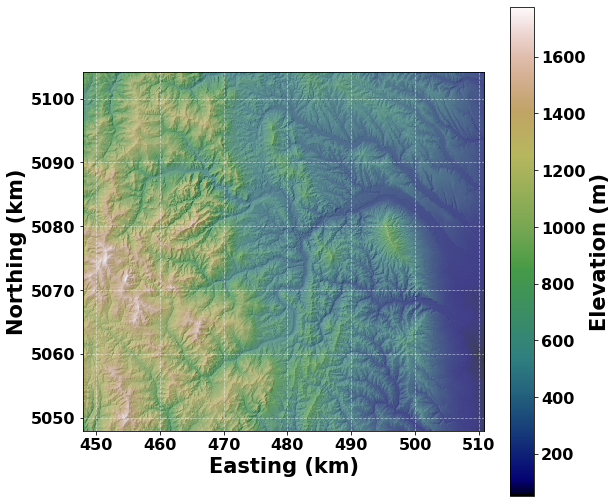

In [3]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,9))
lsd.quickplot.get_basemap(mydem , cmap = "gist_earth", hillshade = True, 
	alpha_hillshade = 0.35, cmin = None, cmax = None,
	hillshade_cmin = 0, hillshade_cmax = 1, colorbar = True, 
	fig = fig, ax = ax, colorbar_label = "Elevation (m)", colorbar_ax = None, normalise_HS = True)

## Calculating common flow routines

TODO: reference and anrguments. 

In [4]:
mydem.CommonFlowRoutines()

Processing common flow routines...
Done!


**Having a look on the drainage are raster**

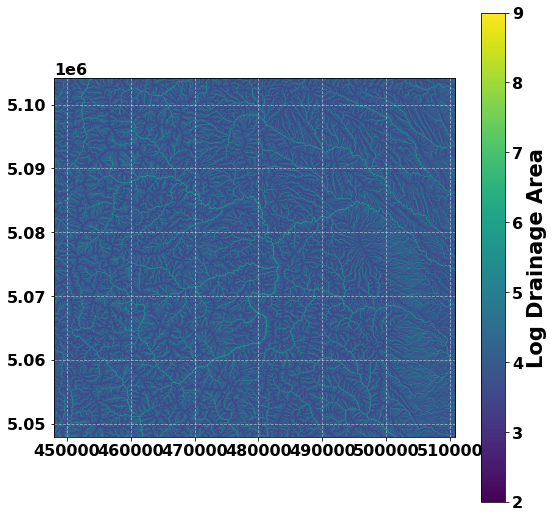

In [5]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,9))
cb = ax.imshow(np.log10(mydem.cppdem.get_DA_raster()), extent = mydem.extent, vmin = 2, vmax = 9, cmap = "viridis")
plt.colorbar(cb, label = "Log Drainage Area")

## Defining the drainage networka nd area of interest

`lsdtopytools` works as follow. First it needs to define channel heads, their sources. So far in `lsdtopytools` (the python bindings), the only method available is area threshold. You define a number of accumulated pixels minimum to initiate the river network. Smaller numbers = denser network.
Then, the code needs to know your basin(s) of interest. The easiest method is `main_basin` to extract the biggest basin.
TODO: explain the others

In [6]:
mydem.ExtractRiverNetwork( method = "area_threshold", area_threshold_min = 300)
catch_coord = mydem.DefineCatchment( method = "main_basin")
mydem.GenerateChi(theta = 0.3, A_0 = 1)

This appears to be a channel made up of a single pixel!


**Visualise the river network**

`mydem.df_base_river` is at this point is a pandas dataframe with all the river info: elevation, flow_distance, drainage_area, ...

TODO: detail that part

Hillshading with altitude: 45, azimuth: 315 and z-factor: 1
This appears to be a channel made up of a single pixel!
LINE 330 LSDIndexChannel Not in channel!
Using the 0 node
0
0


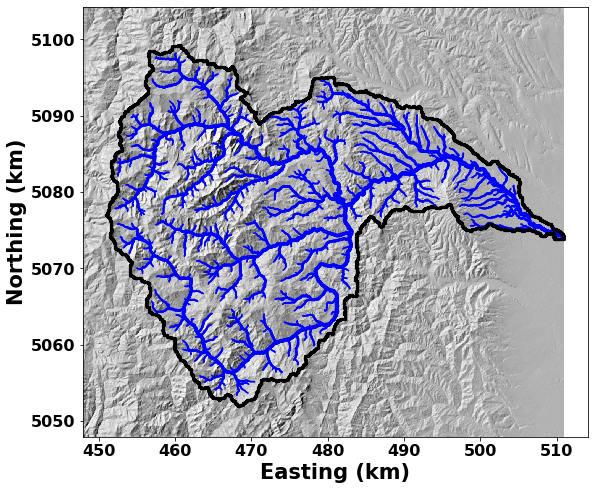

In [7]:
fig, ax = lsd.quickplot.get_basemap(mydem , figsize = (9,9), cmap = "gist_earth", hillshade = True, 
	alpha_hillshade = 1, cmin = None, cmax = None,
	hillshade_cmin = 0, hillshade_cmax = 1, colorbar = False, 
	fig = None, ax = None, colorbar_label = None, colorbar_ax = None, fontsize_ticks = 16, normalise_HS = True)
size_array = lsd.size_my_points(np.log10(mydem.df_base_river.drainage_area), 2,15)
ax.scatter(mydem.df_base_river.x, mydem.df_base_river.y, lw=0, c= "b",  zorder = 5, s=size_array)
lsd.quickplot_utilities.add_basin_outlines(mydem, fig, ax, size_outline = 10, zorder = 5, color = "k")

Text(0.5, 0, 'Distance from outlet (m)')

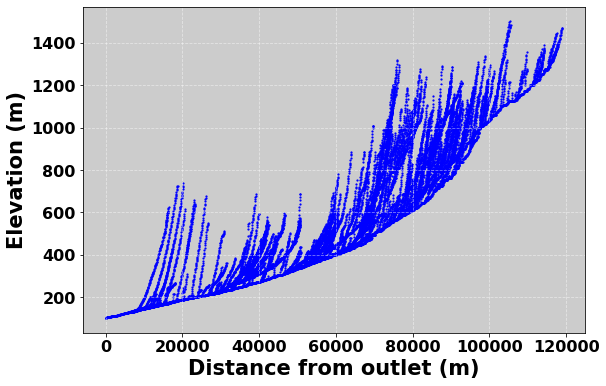

In [8]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,6))
df = mydem.df_base_river
mask = (df["basin_key"] ==0)
ax.scatter(df["flow_distance"][mask],df["elevation"][mask], c = "b", s = 5, lw =0)
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Distance from outlet (m)")

## Constrain the optimal concavity

TODO: explain (running out of time sorry)

See https://esurf.copernicus.org/articles/6/505/2018/ for method!

In [9]:
# params = [0,catch_coord["X"],catch_coord["Y"],1500,"concavity_processing_"]
concavitydem = lsd.LSDDEM(path = "./", file_name = "putna_50_NDF.tif", already_preprocessed = False)
concavitydem.PreProcessing()
concavitydem.CommonFlowRoutines()
res = lsd.concavity_automator.theta_quick_constrain_single_basin(concavitydem,X_coordinate_outlet = catch_coord["X"], 
                                                                 Y_coordinate_outlet = catch_coord["Y"], area_threshold = 5000)

Loading the raster from file: ./putna_50_NDF.tif
LOADING TOOK 0.06644392013549805
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.0023088455200195312
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.005199909210205078I am an empty LSDJunctionNetwork
Nrows:1127 and ncols:1260
out Nrows:1127 and out ncols:1260


I am an empty LSDJunctionNetwork
Yes, yes, we know. Ignore the above depressing debugging text, that's perfectly normal to feel empty sometimes.
FINALISATION TOOK 0.0052111148834228516
lsdtopytools is now ready to roll!
Carving: implementation of Lindsay (2016) DOI: 10.1002/hyp.10648
Filling: implementation of Wang and Liu (2006): https://doi.org/10.1080/13658810500433453
Processing...
I am going to carve/breach your depressions in order to force flow paths.
I am using an algorithm from Lindsay et al., 2016 DOI:https://doi.org/10.1002/hyp.10648
Implementation adapted from RichDEM: https://github.com/r-barnes/richdem



**Thanks for constraning** $\theta$ with the disorder algorithm from _Mudd et al., 2018_ and _Gailleton et al, submitted_.

Keep in mind that it is not straightforward and that the "best fit" we suggest is most of the time the "least worst" value maximising the collinearity in $\chi$ space. 

Especially in large, complex basin, several $\theta$ actually fit different areas and the best fit is just a try to make everyone happy where it is not necessarily possible.

$\theta$ constraining results:

median $\theta$ | $1^{st}$ Q | $3^{rd}$ Q
--- | --- | ---
0.3 | 0.2 | 0.425
		

## Generating the transformed coordinate chi

I am using the median $\theta$ value from above.

TODO: point to the right literrature and expand on implication of a bad $\theta$

In [10]:
mydem.GenerateChi(theta = 0.3, A_0 = 1)

## Segmenting the profile to get $k_{sn}$

Using Mudd et al., 2014 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013JF002981)

TODO: add explanations here and the meaning of parameters. In short, higher target_nodes and skip will tend to create longer segments and represent larger-scale signals. Do not exceed target_nodes =120 if you want to be alive when the results are ready. 

In [11]:
mydem.ksn_MuddEtAl2014(target_nodes=30, n_iterations=60, skip=1, nthreads = 1)

I have generated ksn for the specified region!
Let me just save the result to the hdf5 file to keep track


'generated'

**Visualisation of $k_{sn}$**

TODO: add profile and visualisation of the segment. Explanations about the different columns in mydem.df_ksn.m_chi. Note that `m_chi` is $k_{sn}$ if $A_0 == 1$

Hillshading with altitude: 45, azimuth: 315 and z-factor: 1
This appears to be a channel made up of a single pixel!
LINE 330 LSDIndexChannel Not in channel!
Using the 0 node
0
0


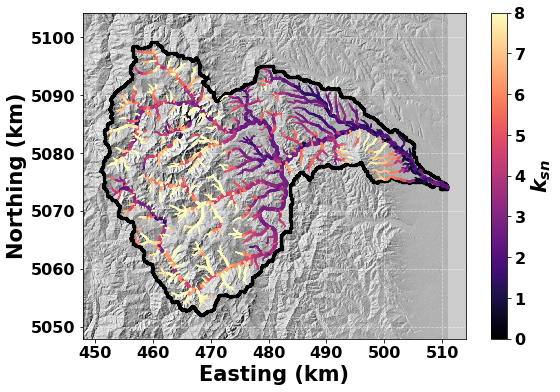

In [12]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,6))
lsd.quickplot.get_basemap(mydem , figsize = (9,9), cmap = "gist_earth", hillshade = True, 
	alpha_hillshade = 1, cmin = None, cmax = None,
	hillshade_cmin = 0, hillshade_cmax = 1, colorbar = False, 
	fig = fig, ax = ax, colorbar_label = None, colorbar_ax = None, fontsize_ticks = 16, normalise_HS = True)
size_array = lsd.size_my_points(np.log10(mydem.df_ksn.drainage_area), 1,15)
lsd.quickplot_utilities.add_basin_outlines(mydem, fig, ax, size_outline = 10, zorder = 5, color = "k")
cb = ax.scatter(mydem.df_ksn.x, mydem.df_ksn.y, lw=0, c= mydem.df_ksn.m_chi, cmap = "magma", zorder = 5, s=size_array, vmin = 0, vmax = 8)
plt.colorbar(cb, label = r"$k_{sn}$")

## Polyfit metrics: 

Polyfit metrics calculate "basic" raw metrics (gradient, curvature, ...) by fitting an equation of a plane over a given pixel window for each pixels. Larger window = larger-scale estimated

In [13]:
metrics = mydem.get_polyfit_metrics(window_radius = 200, average_elevation = True, slope = True, aspect = False, curvature = True) #, planform_curvature = False, profile_curvature = False, tangential_curvature = False, TSP = False, save_to_rast = True):


./putna_50_NDF/average_elevation_200.tif
./putna_50_NDF/slope_200.tif
./putna_50_NDF/curvature_200.tif


**Visualisation**

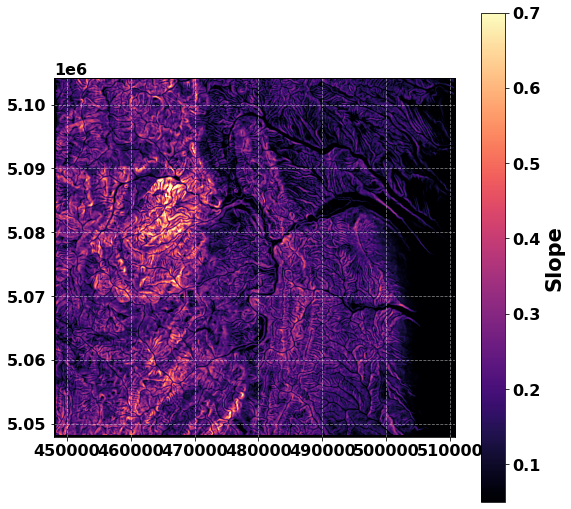

In [14]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,9))


cb = ax.imshow(metrics["slope"], extent = mydem.extent, vmin = 0.05, vmax = 0.7,  cmap = "magma")
plt.colorbar(cb, label = "Slope")

In [15]:
from scipy import stats
kernel = stats.gaussian_kde(res[0])
position = np.arange(0.05,0.6,0.001)

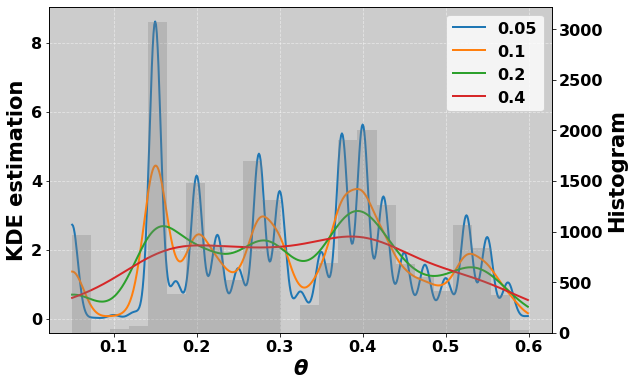

In [16]:
fig, ax = hpl.mkfig_grey_bold(fontsize_major = 21, fontsize_minor = 16, family = "arial" , figsize = (9,6))
kernel.set_bandwidth(0.05)
ax.plot(position,kernel(position), label = "0.05", lw=2)
kernel.set_bandwidth(0.1)
ax.plot(position,kernel(position), label = "0.1", lw=2)
kernel.set_bandwidth(0.2)
ax.plot(position,kernel(position), label = "0.2", lw=2)
kernel.set_bandwidth(0.4)
ax.plot(position,kernel(position), label = "0.4", lw=2)
ax2 = ax.twinx()
ax2.hist(res[0], bins = 24, alpha = 0.3, color = "grey")
ax.legend()
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("KDE estimation")
ax2.set_ylabel("Histogram")
plt.savefig("KDE_bandwidth.png")